### Data - Exploration, Preparation, Train-Val-Test Split

Dataset was imported from [Kaggle](https://www.kaggle.com/datasets/zulkarnainsaurav/imdb-text-classification)

This dataset comprises 1000 IMDB movie/series plot summaries, evenly distributed across four genres: ‘Action’, ‘Comedy’, ‘Romance’, and ‘Horror’. Each instance, represented by a unique ID, corresponds to a single movie/series. The dataset, structured as a CSV file, includes three columns: a unique ID, the plot summary, and the genre label. This multi-class dataset is ideal for genre-based text classification tasks.

In [1]:
import pandas as pd
df = pd.read_csv('IMDB_larger_description_dataset.csv')
df.head()

,movie_id,description,genre
0,tt12783454,Elle Evans (Joey King) has finally completed h...,romance
1,tt1798632,A young girl tries to understand how she myste...,horror
2,tt9214832,"In 1800s England, a well meaning but selfish y...",comedy
3,tt8522006,Abby Holland (Kristen Stewart) and Harper Cald...,romance
4,tt21249656,Olga and Maks are 15 years apart. She is a suc...,romance


In [3]:
df.shape

(1000, 3)

At first I let's encode genre using get_dummies

In [5]:
one_hot_genres = pd.get_dummies(df['genre'])
genre_totals = one_hot_genres.sum()
print(genre_totals)

action     250
comedy     250
horror     250
romance    250
dtype: int64


We can see that each genre is presented equally, so this is a balanced dataset.

Now we can create X and y. X - text description, y - genre.

In [7]:
X=list(df['description'])

In [9]:
y = pd.get_dummies(df['genre']).values.tolist()

In [11]:
# Get the mapping from column names to one-hot encoded positions
genre_mapping = pd.get_dummies(df['genre']).columns.tolist()
print(genre_mapping)

['action', 'comedy', 'horror', 'romance']


Splitting dataset into train (80%) and test (20%).

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

Further splitting of train part into train (80%) and validation (20%) sets.

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 0)

In [17]:
print(f'X_train = {len(X_train)}')
print(f'y_train = {len(y_train)}')
print(f'X_test = {len(X_test)}')
print(f'y_test = {len(y_test)}')
print(f'X_val = {len(X_val)}')
print(f'y_val = {len(y_val)}')

X_train = 640
y_train = 640
X_test = 200
y_test = 200
X_val = 160
y_val = 160


### Transformer Model - Compile, Fine-tune, Train

As a model I took Distil Bert pre-trained model. And further I will fine-tune it.

In [19]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

In [20]:
# Defining tokenizer and loading pre-trained Transformer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

/opt/anaconda3/envs/tf_env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTor

We need to create tensorflow dataests to send them to the model.

In [23]:
# Convert one-hot encoded labels (True-False lists) to float32 TensorFlow tensors
train_labels = tf.convert_to_tensor(y_train, dtype=tf.float32)
val_labels = tf.convert_to_tensor(y_val, dtype=tf.float32)

In [25]:
# Data Preparation - Creating tf datasets

# 1 - get text
train_data = [{'text': text} for text in X_train]
val_data = [{'text': text} for text in X_val]

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# 2 - fetched text present in the tokenized way
train_dataset = list(map(tokenize_function, train_data))
val_dataset = list(map(tokenize_function, val_data))

# 3 - converting columns to tensors
train_features = {
    'input_ids': tf.convert_to_tensor([f['input_ids'] for f in train_dataset]),
    'attention_mask': tf.convert_to_tensor([f['attention_mask'] for f in train_dataset])
}

val_features = {
    'input_ids': tf.convert_to_tensor([f['input_ids'] for f in val_dataset]),
    'attention_mask': tf.convert_to_tensor([f['attention_mask'] for f in val_dataset])
}

# 4 - combining all together to tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(8)
val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).batch(16)

train_dataset = train_dataset.repeat()
val_dataset = val_dataset.repeat()

Defining the baseline parameters: learning_rate=5e-5.

In [28]:
# Defining Loss Function as Categorical Crossentropy as we have multiple classes to classify
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Compiling model, using Adam as an optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5, weight_decay=0.01),
    loss=loss_fn,
    metrics=['accuracy'],
)

In [176]:
# Using TensorBoard for logging
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

# Training the model
starting_model_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=len(X_train) // 8,
    validation_steps=len(X_test) // 16,
    callbacks=[tensorboard_callback],
)

Epoch 1/10
80/80 [==============================] - 416s 5s/step - loss: 0.0906 - accuracy: 0.9750 - val_loss: 1.1018 - val_accuracy: 0.6927
Epoch 2/10
80/80 [==============================] - 518s 6s/step - loss: 0.0361 - accuracy: 0.9922 - val_loss: 0.9962 - val_accuracy: 0.7396
Epoch 3/10
80/80 [==============================] - 548s 7s/step - loss: 0.0120 - accuracy: 0.9984 - val_loss: 1.0705 - val_accuracy: 0.7396
Epoch 4/10
80/80 [==============================] - 614s 8s/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1300 - val_accuracy: 0.7448
Epoch 5/10
80/80 [==============================] - 678s 8s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.1756 - val_accuracy: 0.7500
Epoch 6/10
80/80 [==============================] - 626s 8s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.2116 - val_accuracy: 0.7552
Epoch 7/10
80/80 [==============================] - 540s 7s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.2519 - val_accuracy: 0.7552
Epoch 8/10
80

### Evaluation on the Test Data (Unseen)

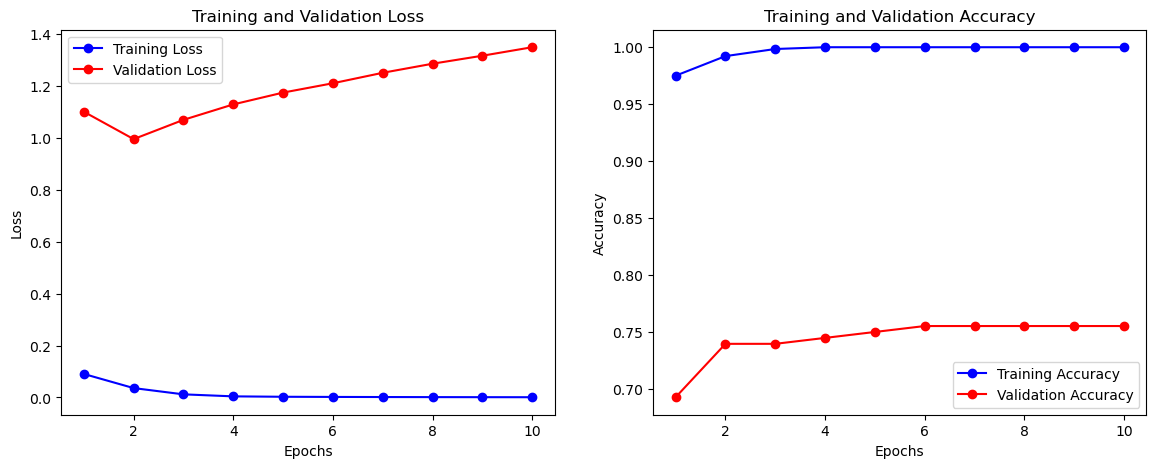

In [178]:
import matplotlib.pyplot as plt

# Plot the learning curves
def plot_learning_curves(history):
    # Extract loss and accuracy from the history object
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    train_accuracy = history.history.get('accuracy', [])
    val_accuracy = history.history.get('val_accuracy', [])

    # Determine the number of epochs
    epochs = range(1, len(train_loss) + 1)
    min_len = min(len(train_loss), len(val_loss))  # Find the minimum length

    # Truncate data to the minimum length
    if len(train_loss) != len(val_loss):
        print(f"Truncating to minimum length {min_len} due to mismatch.")
        train_loss = train_loss[:min_len]
        val_loss = val_loss[:min_len]
        train_accuracy = train_accuracy[:min_len]
        val_accuracy = val_accuracy[:min_len]
        epochs = range(1, min_len + 1)

    # Plot training and validation loss
    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call the function to plot learning curves
plot_learning_curves(starting_model_history)

**Training and Validation Loss:** <br>
- Training Loss: The training loss rapidly decreases to near zero, which is a sign that the model is fitting the training data extremely well.
- Validation Loss: The validation loss initially decreases but then starts to increase steadily. This is a strong indication of **overfitting**, where the model continues to improve on the training data but performs worse on unseen validation data. <br>

**Training and Validation:** <br>
- Training Accuracy: The training accuracy quickly reaches near 100%, indicating that the model is learning the training data too well, which can often mean it is **memorizing rather than generalizing**.
- Validation Accuracy: The validation accuracy improves initially but then plateaus and slightly fluctuates, not reaching the same level as the training accuracy. This plateau suggests that the model is **not generalizing well** to the validation data, likely due to overfitting.<br>

**Summary:** <br>
The most prominent issue is overfitting. The model is too complex for the data, leading to a situation where it performs exceptionally well on the training set but poorly on the validation set.

In [167]:
# Defining test_dataset
test_labels = tf.convert_to_tensor(y_test, dtype=tf.float32)
test_data = [{'text': text} for text in X_test]
test_dataset = list(map(tokenize_function, test_data))
test_features = {
    'input_ids': tf.convert_to_tensor([f['input_ids'] for f in test_dataset]),
    'attention_mask': tf.convert_to_tensor([f['attention_mask'] for f in test_dataset])
}
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(16)

In [168]:
model.evaluate(test_dataset)

13/13 [==============================] - 27s 2s/step - loss: 0.9474 - accuracy: 0.7300


[0.9474359750747681, 0.7300000190734863]

### Playground - test on your text

In [48]:
def prediction(text):
    tokenized_text = tokenizer(text, padding='max_length', truncation=True, return_tensors='tf')
    logits = model(tokenized_text).logits
    probabilities = tf.nn.softmax(logits, axis=-1)
    predicted_genre = tf.argmax(probabilities, axis=-1)

    result = 0
    if predicted_genre.numpy() == 0:
        result = 'action'
    elif predicted_genre.numpy() == 1:
        result = 'comedy'
    elif predicted_genre.numpy() == 2:
        result = 'horror'
    elif predicted_genre.numpy() == 3:
        result = 'romance'
    else:
        result = "I don't know"
    return result, probabilities.numpy()

In [50]:
# JAWS
text = '''
It's a hot summer on Amity Island, a small community whose primary business is its beaches. When new Sheriff Martin Brody discovers the remains of a shark attack victim, his first inclination is to close the beaches to swimmers. It doesn't sit well with Mayor Larry Vaughn and several local business people. Brody backs down to his regret of that weekend. A predator kills a young boy. The dead boy's mother puts out a bounty on the shark, and Amity is soon swamped with amateur hunters and fishermen hoping to cash in on the reward. A local fisherman with much experience hunting sharks, Quint, offers to hunt down the creature for a hefty fee. Soon, Quint, Brody, and Matt Hooper from the Oceanographic Institute are hunting the Great White shark at sea. As Brody succinctly surmises after their first encounter with the creature, they will need a bigger boat.—garykmcd
'''
prediction(text)

('comedy',
 array([[0.04890006, 0.80089206, 0.08725858, 0.06294936]], dtype=float32))

In [52]:
# PULP FICTION
text = '''
Jules Winnfield (Samuel L. Jackson) and Vincent Vega (John Travolta) are two hitmen who are out to retrieve a suitcase stolen from their employer, mob boss Marsellus Wallace (Ving Rhames). Wallace has also asked Vincent to take his wife Mia (Uma Thurman) out a few days later when Wallace himself will be out of town. Butch Coolidge (Bruce Willis) is an aging boxer who is paid by Wallace to lose his fight. The lives of these seemingly unrelated people are woven together comprising of a series of funny, bizarre and uncalled-for incidents.—Soumitra.
'''
prediction(text)

('action',
 array([[0.9003394 , 0.05201437, 0.01403995, 0.03360637]], dtype=float32))

In [54]:
# TITANIC
text = '''
On a doomed luxury liner, first-class passenger Rose finds a love to last a lifetime when she falls for penniless artist Jack just as disaster strikes.
'''
prediction(text)

('romance',
 array([[0.00918279, 0.0385508 , 0.01568298, 0.93658346]], dtype=float32))

In [56]:
# THE DUMB AND THE DUMBER
text = '''
Lloyd and Harry are two men whose stupidity is really indescribable. When Mary, a beautiful woman, loses an important suitcase with money before she leaves for Aspen, the two friends (who have found the suitcase) decide to return it to her. After some "adventures" they finally get to Aspen where, using the lost money they live it up and fight for Mary's heart.
'''
prediction(text)

('comedy',
 array([[0.05716195, 0.73161405, 0.04928992, 0.16193399]], dtype=float32))

In [58]:
# THE MASK
text = '''
A hapless bank teller discovers an ancient mask that turns him into a zany prankster who acts on his deepest desires.
'''
prediction(text)

('comedy',
 array([[0.05891549, 0.7008552 , 0.10252255, 0.13770671]], dtype=float32))

We will investigate each incorrectly predicted case.

### Misclassified Cases Investigation

Also it is a good practise to check cases where model performed poorly.

In [171]:
import numpy as np

predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions.logits, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Identifying misclassified cases
misclassified_indices = np.where(predicted_labels != true_labels)[0]
misclassified_texts = [X_test[i] for i in misclassified_indices]

for i in range(len(misclassified_texts)):
    print(f"Text: {misclassified_texts[i]}")
    print(f"True Label: {true_labels[misclassified_indices[i]]}")
    print(f"Predicted Label: {predicted_labels[misclassified_indices[i]]}\n")

13/13 [==============================] - 29s 2s/step
Text: Teen best friends Cecilia and Emma, run into each other after a decade. Cecilia is invited to Emma's bachelorette weekend where she gets stuck in a remote cabin with her high school bully and a taste for revenge. Cecilia (aka Sissy) is a successful social media influencer living the dream, until she runs into her ex-childhood best friend and is invited away on her bachelorette weekend. Suddenly Sissy finds herself stuck in a remote cabin with her school bully and a taste for revenge. 
True Label: 2
Predicted Label: 1

Text: The film opens on an island resort in the Philippines. Families and friends are gathered for the wedding of Darcy Rivera (Jennifer Lopez) and Tom Fowler (Josh Duhamel). Darcy shows up to a dinner where she meets with her mother, Renata (Sonia Braga), who thinks the big wedding is too flashy. Meanwhile, Tom is setting up a surprise for Darcy on a motorboat but gets startled by the security guard, causing him 

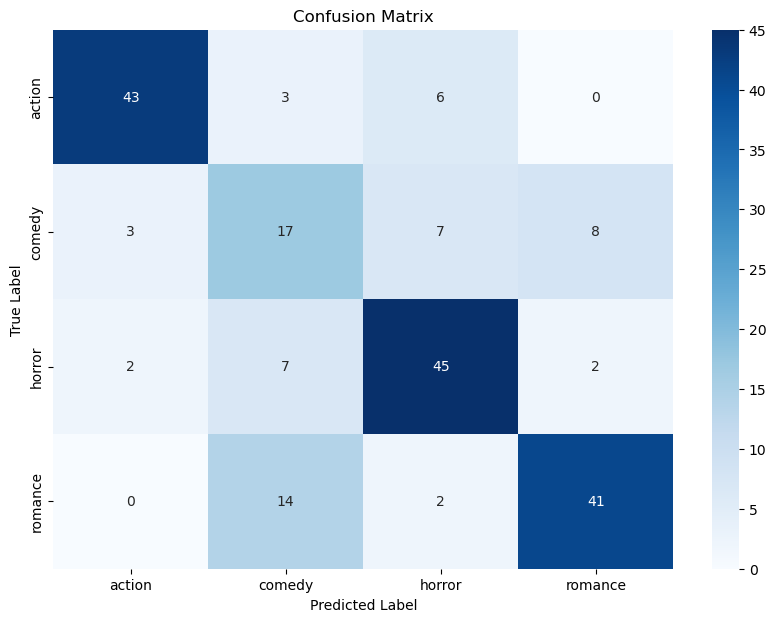

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['action', 'comedy', 'horror', 'romance'], yticklabels=['action', 'comedy', 'horror', 'romance'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In the diagonal we can see correctly predicted labels. <br>
Outside diagonal - all incorrect predictions. Top labels which were predicted incorrecltly: <br>
1. **Predicted Comedy** when **True is Romance** - 14 cases. <br>
2. **Predicted Romance** - **True Comedy** - 8 cases. <br>
3. **Predicted Comedy** - **True Horror** - 7 cases. <br>
4. **Predicted Horror** - **True Comedy** - 7 cases.

### Next Stepts to prevent Overfitting

We can add **L2 Regularization (Ridge Regularization)** to prevent overfitting. <br>
L2 adds a penalty term to the loss function that is proportional to the square of the magnitude of the coefficients. This encourages the model to keep the coefficients small, which can help improve the generalization of the model.<br>

Also we can adjust lr (**learning rate**). It controls how much the model's parameters are adjusted with respect to the loss gradient during each iteration of the training process.<br>
Small lr (means that model takes tiny steps) and it will convergence more slowly. High lr will do the opposite, it can lead to divergence or oscillation around the minimum. <br>

**Early Stopping** - monitors the model's performance on a validation set and halting the training process when the performance begins to degrade, indicating that the model is starting to overfit to the training data. We can control it by setting the patience parameter.